In [4]:
import numpy as np
import os

path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    print('Loading accuracy...')
    accuracy =  np.load(path)
    print(accuracy)

Loading accuracy...
[[ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 ..., 
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]]


### Préparer l'apprentissage

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from LogGabor import LogGabor

def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 12, 5, 2, 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

energy = (phi**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape(((N_orient)*N_scale, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)

def accuracy_128(i_offset, j_offset):
    N_pic = 128
    center = (128-55)//2
    
    accuracy_128 = 0.1 * np.ones((N_pic,N_pic))
    accuracy_128[(center+i_offset):(center+55+i_offset),(center+j_offset):(center+55+j_offset)] = accuracy
    
    accuracy_LP = energy_vector @ np.ravel(accuracy_128)
    
    return accuracy_LP

def mnist_128(data, i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    data_128 = data.min() * np.ones((128,128))
    data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

    data_LP = phi_vector @ np.ravel(data_128)
     
    return data_LP

def couples(data, i_offset, j_offset):
    v = mnist_128(data, i_offset, j_offset)
    a = accuracy_128(i_offset, j_offset)
    
    return (v,a)

def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return value

def sigmoid(values):
    values = 1 / (1 + ((1 / 0.1) - 1) * np.exp(-values))
        
    return values

### Construction du nn apprenant la correspondance input/certitude avec transformées LogPol

In [19]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from LogGabor import LogGabor
import numpy as np
import time

sample_size = 100 #quantity of examples that'll be processed

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=True,    #def the dataset as training data 
                   download=True, #download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=sample_size, 
                   shuffle=True)

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, data):
        data = F.relu(self.hidden(data))
        data = self.predict(data)
        data = F.sigmoid(data)
        return data
    
net = Net(n_feature=720, n_hidden=260, n_output=60)
optimizer = torch.optim.SGD(net.parameters(), lr=0.3)
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()

def train(epoch_nb, sample_size):
    t_start = time.time()
    print('Starting training...')
    for epoch in range(epoch_nb):
        for batch_idx, (data, label) in enumerate(data_loader):
            data_v, data_a = np.zeros((sample_size, 1, 720)), np.zeros((sample_size, 1, 60))
            for idx in range(sample_size):
                i_offset, j_offset = minmax(np.random.randn()*5, 35), minmax(np.random.randn()*5, 35)
                v, a = couples(data[idx,0,:], i_offset, j_offset)
                data_v[idx,0,:], data_a[idx,0,:] = v, a

            data_v, data_a = torch.FloatTensor(data_v), torch.FloatTensor(data_a)
            data_v, data_a = Variable(data_v), Variable(data_a)

            prediction = net(data_v)
            print(prediction.data.min(), prediction.data.max())
            loss = loss_func(prediction, data_a)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Epoch {}: [{}/{}] Loss: {} Time: {:.2f} mn'.format(
                    epoch, batch_idx*sample_size, len(data_loader.dataset), 
                    loss.data.numpy(), (time.time()-t_start)/60))
    print('...Training done')
    
def evaluation():
    print('Starting evaluation...')
    for batch_idx, (data, label) in enumerate(data_loader):
        data_v, data_a = np.zeros((1, 1, 720)), np.zeros((1, 1, 60))

        i_offset, j_offset = minmax(np.random.randn()*10, 30), minmax(np.random.randn()*10, 30)
        print('i_offset: {}, j_offset: {}'.format(i_offset, j_offset))
        v, a = couples(data[0,0,:], i_offset, j_offset)
        data_v[0,0,:], data_a[0,0,:] = v, a

        data_v, data_a = torch.FloatTensor(data_v), torch.FloatTensor(data_a)
        data_v, data_a = Variable(data_v), Variable(data_a)

        prediction = net(data_v)
        
        pred_data = prediction.data.numpy()[-1][-1]

        image = energy_plus @ pred_data
        image = sigmoid(image)
        image_reshaped = image.reshape(128,128)
        
        fig, ax = plt.subplots(figsize=(13,10.725))
        cmap = ax.pcolor(np.arange(-64,64), np.arange(-64,64), image_reshaped)
        fig.colorbar(cmap)
        
        for i_offset in range(-65,64):
            for j_offset in range(-64,64):
                if image_reshaped[i_offset][j_offset] == image_reshaped.max():
                    print(i_offset, j_offset, image_reshaped.max())
        
        print('...Evaluation done')
        break

### Lancement apprentissage/évaluation

In [36]:
path = 'regression_couples.pt'

if os.path.isfile(path):
    print('Loading file', path)
    net.load_state_dict(torch.load(path))
else:
    print('Training model...')
    epoch_nb = 1      #number of training epochs
    train(epoch_nb, sample_size)
    torch.save(net.state_dict(), path)
    print('Model saved at', path)

Loading file regression_couples.pt


Starting evaluation...
i_offset: 0.22069811810417722, j_offset: -12.3281985744008
-65 53 0.202180446846
63 53 0.202180446846
...Evaluation done


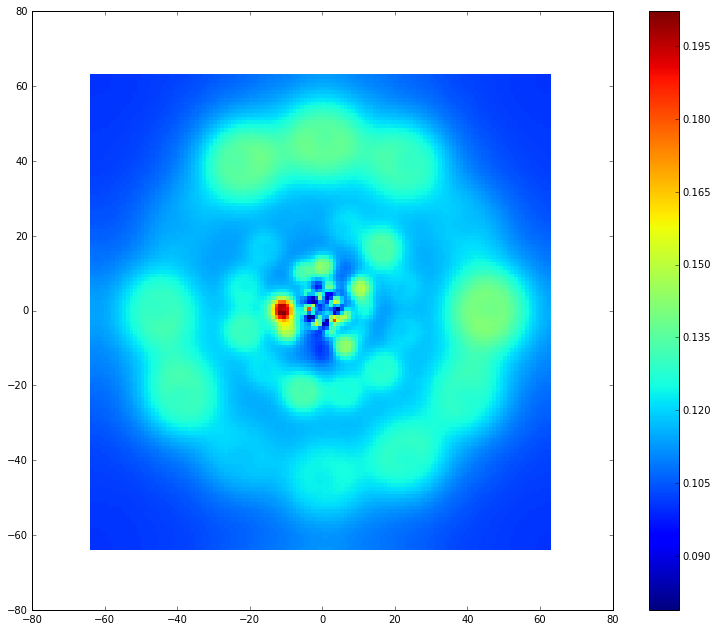

In [47]:
evaluation()